In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
precios = pd.read_csv('precios-en-surtidor-resolucin-3142016.csv')

# ¿Qué tenemos en éste dataset?

La propiedad `.shape` nos da las dimensiones que tiene el dataset (filas, columnas)

In [3]:
precios.shape

(33781, 18)

El método `head()` nos permite ver las primeras N filas (5 por default).

In [4]:
precios.head()

,idempresa,cuit,empresa,direccion,localidad,provincia,region,idproducto,producto,idtipohorario,tipohorario,precio,fecha_vigencia,idempresabandera,empresabandera,latitud,longitud,geojson
0,1376,33-64337382-9,10 DE SETIEMBRE S.A.,Av. Mosconi 299,LOMAS DEL MIRADOR,BUENOS AIRES,PAMPEANA,6,GNC,2,Diurno,8.79,2017-03-27 10:38:00,1,BLANCA,-34.658476,-58.529443,"{""type"":""Point"",""coordinates"":[-58.529443,-34...."
1,1376,33-64337382-9,10 DE SETIEMBRE S.A.,Av. Mosconi 299,LOMAS DEL MIRADOR,BUENOS AIRES,PAMPEANA,6,GNC,3,Nocturno,8.79,2017-03-27 10:38:00,1,BLANCA,-34.658476,-58.529443,"{""type"":""Point"",""coordinates"":[-58.529443,-34...."
2,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,19,Gas Oil Grado 2,2,Diurno,14.96,2017-04-06 20:51:00,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."
3,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,19,Gas Oil Grado 2,3,Nocturno,14.96,2017-04-06 20:51:00,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."
4,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,21,Gas Oil Grado 3,2,Diurno,16.75,2017-04-06 20:52:00,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."


El método `describe()` nos muestra un poco de estadística descriptiba sobre aquellas columnas numéricas

In [5]:
precios.describe()

,idempresa,idproducto,idtipohorario,precio,idempresabandera,latitud,longitud
count,33781.000000,33781.000000,33781.000000,33781.000000,33781.000000,33767.000000,33767.000000
mean,4437.204908,10.694503,2.499956,25.646718,6.011219,-33.441135,-61.635892
std,2781.111519,8.468580,0.500007,5.159886,7.818441,4.136823,3.628216
min,102.000000,2.000000,2.000000,7.000000,1.000000,-54.829501,-72.338930
25%,1794.000000,3.000000,2.000000,23.560000,2.000000,-34.787240,-64.264660
50%,4132.000000,6.000000,2.000000,26.660000,2.000000,-33.901050,-60.693180
75%,7051.000000,19.000000,3.000000,28.990000,4.000000,-31.459007,-58.559811
max,9252.000000,21.000000,3.000000,35.490000,28.000000,-22.055820,-53.648260


El método `info()` nos da información sobre las columnas que tiene el dataset, la cantidad filas que tienen datos (non-null) en la misma y el tipo de dato.

In [6]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33781 entries, 0 to 33780
Data columns (total 18 columns):
idempresa           33781 non-null int64
cuit                33781 non-null object
empresa             33781 non-null object
direccion           33767 non-null object
localidad           33781 non-null object
provincia           33781 non-null object
region              32857 non-null object
idproducto          33781 non-null int64
producto            33781 non-null object
idtipohorario       33781 non-null int64
tipohorario         33781 non-null object
precio              33781 non-null float64
fecha_vigencia      33781 non-null object
idempresabandera    33781 non-null int64
empresabandera      33781 non-null object
latitud             33767 non-null float64
longitud            33767 non-null float64
geojson             33767 non-null object
dtypes: float64(3), int64(4), object(11)
memory usage: 4.6+ MB


# Preparación y tranformación de datos

Cuando trabajamos con datos de fuentes externas a las cuales no tenemos control, siempre necesitaremos manipular y traformar esos datos según nuestras necesidades.

### Primer paso: Quitar horas y minutos
Lo primero que haremos, es quitar la hora y los minutos porque no nos interesan.

`.str` es una propiedad que nos permite acceder a métodos y atributos específios para la manipulación de strings.

In [7]:
precios['fecha_vigencia'] = precios['fecha_vigencia'].str.slice(0, 10)  # '27/03/2017 10:38' -> '27/03/2017'
precios.head()

,idempresa,cuit,empresa,direccion,localidad,provincia,region,idproducto,producto,idtipohorario,tipohorario,precio,fecha_vigencia,idempresabandera,empresabandera,latitud,longitud,geojson
0,1376,33-64337382-9,10 DE SETIEMBRE S.A.,Av. Mosconi 299,LOMAS DEL MIRADOR,BUENOS AIRES,PAMPEANA,6,GNC,2,Diurno,8.79,2017-03-27,1,BLANCA,-34.658476,-58.529443,"{""type"":""Point"",""coordinates"":[-58.529443,-34...."
1,1376,33-64337382-9,10 DE SETIEMBRE S.A.,Av. Mosconi 299,LOMAS DEL MIRADOR,BUENOS AIRES,PAMPEANA,6,GNC,3,Nocturno,8.79,2017-03-27,1,BLANCA,-34.658476,-58.529443,"{""type"":""Point"",""coordinates"":[-58.529443,-34...."
2,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,19,Gas Oil Grado 2,2,Diurno,14.96,2017-04-06,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."
3,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,19,Gas Oil Grado 2,3,Nocturno,14.96,2017-04-06,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."
4,8943,30-71251168-7,1913 SRL,Julio A Roca 715,GOBERNADOR COSTA,CHUBUT,PATAGONIA,21,Gas Oil Grado 3,2,Diurno,16.75,2017-04-06,26,AXION,-44.050662,-70.583041,"{""type"":""Point"",""coordinates"":[-70.583041,-44...."


### Segundo paso: Convertir string a Date
Pandas interpretó la columna `fecha_vigencia` como string porque no conoce el formato de fecha que tiene, sin embargo, nosotros necesitamos que pandas entienda que dicha columna es una fecha. 

`.to_datetime()` convierte un string a un objeto de tipo DateTime.

In [8]:
precios["fecha_vigencia"] = pd.to_datetime(precios["fecha_vigencia"])
precios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33781 entries, 0 to 33780
Data columns (total 18 columns):
idempresa           33781 non-null int64
cuit                33781 non-null object
empresa             33781 non-null object
direccion           33767 non-null object
localidad           33781 non-null object
provincia           33781 non-null object
region              32857 non-null object
idproducto          33781 non-null int64
producto            33781 non-null object
idtipohorario       33781 non-null int64
tipohorario         33781 non-null object
precio              33781 non-null float64
fecha_vigencia      33781 non-null datetime64[ns]
idempresabandera    33781 non-null int64
empresabandera      33781 non-null object
latitud             33767 non-null float64
longitud            33767 non-null float64
geojson             33767 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(10)
memory usage: 4.6+ MB


# Algunas preguntas a responder...

### ¿Cuál es la fecha de la primer medición? ¿Y cuál fue su precio?
`.idxmin()` devuelve el índice correspondiente al menor valor de una columna determinada, en nuestro caso `fecha_vigencia`

`.loc` nos permite acceder a filas através del índice

In [9]:
indice = precios['fecha_vigencia'].idxmin()
print(indice)

precios.loc[ indice ]

30009


idempresa                                                        6365
cuit                                                    30-70751747-2
empresa                                                    SERIGAS SH
direccion                                          AV. SA MARTIN 1050
localidad                                                CNEL. SUAREZ
provincia                                                BUENOS AIRES
region                                                       PAMPEANA
idproducto                                                          6
producto                                                          GNC
idtipohorario                                                       2
tipohorario                                                    Diurno
precio                                                          11.99
fecha_vigencia                                    2016-04-01 00:00:00
idempresabandera                                                    1
empresabandera      

### ¿Cuál es la fecha de la última medición? ¿Y cuál fue su precio?
`.idxmax()` devuelve el índice correspondiente al mayor valor de una columna determinada, en nuestro caso `fecha_vigencia`


In [10]:
indice = precios['fecha_vigencia'].idxmax()
print(indice)

precios.loc[ precios['fecha_vigencia'].idxmax() ]

106


idempresa                                                        3728
cuit                                                    30-50646337-4
empresa                                            ABDALA HNOS.S.R.L.
direccion                                               LIBERTAD 2080
localidad                                         SANTIAGO DEL ESTERO
provincia                                         SANTIAGO DEL ESTERO
region                                                            NOA
idproducto                                                         19
producto                                              Gas Oil Grado 2
idtipohorario                                                       2
tipohorario                                                    Diurno
precio                                                          24.64
fecha_vigencia                                    2018-05-16 00:00:00
idempresabandera                                                    4
empresabandera      

### ¿Donde el precio de la nafta es más caro?

In [11]:
precios.loc[ precios['precio'].idxmax() ]

idempresa                                                        7147
cuit                                                    30-70933773-0
empresa                                           ESTACION COFICO SRL
direccion                                                  BEDOYA 701
localidad                                                     CORDOBA
provincia                                                     CORDOBA
region                                                         CENTRO
idproducto                                                          3
producto                             Nafta (premium) de más de 95 Ron
idtipohorario                                                       2
tipohorario                                                    Diurno
precio                                                          35.49
fecha_vigencia                                    2018-04-09 00:00:00
idempresabandera                                                    1
empresabandera      

### ¿Cuales son los combustibles que disponemos en el dataset?
`.unique()` nos devuelve un array con todos los valores que hay en una columna sin repetir.

In [12]:
combustibles = precios['producto'].unique()
combustibles

array(['GNC', 'Gas Oil Grado 2', 'Gas Oil Grado 3',
       'Nafta (premium) de más de 95 Ron',
       'Nafta (súper) entre 92 y 95 Ron'], dtype=object)

### Para cada tipo de combustible... ¿Donde se encuentra el más caro en lo que va de éste mes?¿Y los más baratos?
#### los más caros
`.dt` (abreviación de **d**ate**t**ime) es una propiedad que nos permite acceder a métodos y atributos específios para la manipulación de fechas. 

`.groupby()` agrupa un conjunto de filas según una o más columnas. Es equivalente a la cláusula `GROUP BY` de `SQL`

In [13]:
precios_mes_actual = precios[
    (precios['fecha_vigencia'].dt.month == 5) & (precios['fecha_vigencia'].dt.year == 2018) 
]

In [14]:
precios_actuales_altos = precios_mes_actual.loc[precios_mes_actual.groupby(by='producto')['precio'].idxmax() ]
precios_actuales_altos[['fecha_vigencia', 'producto', 'empresabandera', 'provincia', 'localidad', 'precio']]

,fecha_vigencia,producto,empresabandera,provincia,localidad,precio
33415,2018-05-09,GNC,BLANCA,MENDOZA,SAN RAFAEL,17.50
25185,2018-05-08,Gas Oil Grado 2,SOL PETROLEO,SANTA FE,PIÑERO,28.10
14635,2018-05-04,Gas Oil Grado 3,BLANCA,CORDOBA,VILLA CARLOS PAZ,31.27
14639,2018-05-04,Nafta (premium) de más de 95 Ron,BLANCA,CORDOBA,VILLA CARLOS PAZ,35.28
14641,2018-05-04,Nafta (súper) entre 92 y 95 Ron,BLANCA,CORDOBA,VILLA CARLOS PAZ,31.89


#### Los más baratos

In [15]:
precios_actuales_altos = precios_mes_actual.loc[precios_mes_actual.groupby(by='producto')['precio'].idxmin() ]
precios_actuales_altos[['fecha_vigencia', 'producto', 'empresabandera', 'provincia', 'localidad', 'precio']]

,fecha_vigencia,producto,empresabandera,provincia,localidad,precio
9175,2018-05-16,GNC,BLANCA,BUENOS AIRES,LLAVALLOL,9.99
15295,2018-05-10,Gas Oil Grado 2,PETROBRAS,RIO NEGRO,SIERRA GRANDE,20.94
15297,2018-05-10,Gas Oil Grado 3,PETROBRAS,RIO NEGRO,SIERRA GRANDE,23.56
24561,2018-05-08,Nafta (premium) de más de 95 Ron,ESSO PETROLERA ARGENTINA S.R.L,RIO NEGRO,BARDA DEL MEDIO,22.96
24563,2018-05-08,Nafta (súper) entre 92 y 95 Ron,ESSO PETROLERA ARGENTINA S.R.L,RIO NEGRO,BARDA DEL MEDIO,20.18


### ¿Cuántas estaciones de servios de cada empresa hay?
`.value_counts()` devulve la cantidad de valores iguales encontrados en una columna

In [16]:
cantidad = precios['empresabandera'].value_counts()
cantidad

YPF                               12916
SHELL C.A.P.S.A.                   5528
BLANCA                             5307
ESSO PETROLERA ARGENTINA S.R.L     3250
OIL COMBUSTIBLES S.A.              2374
PETROBRAS                          2208
AXION                               924
REFINOR                             530
SOL PETROLEO                        346
ASPRO                               170
PUMA                                 96
PDV sur                              36
Pampa Energia                        24
AGIRA                                20
DAPSA S.A.                           18
CAMUZZI GAS DEL SUR                  16
RHASA                                10
CIS                                   8
Name: empresabandera, dtype: int64

`.plot()` es un método que permite realizar distintos tipos de gráficos de manera rápida.

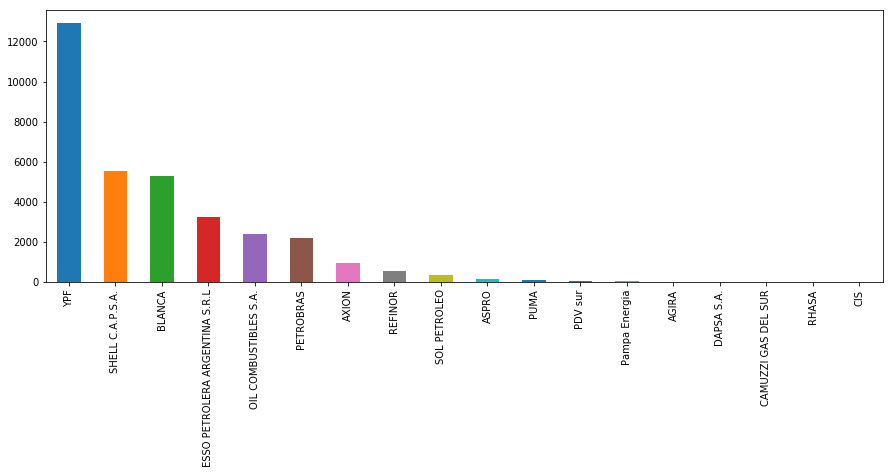

In [17]:
cantidad.plot(kind='bar', figsize=(15, 5))

### ¿Cómo fue el comportamiento de cada combustible en Corrientes?

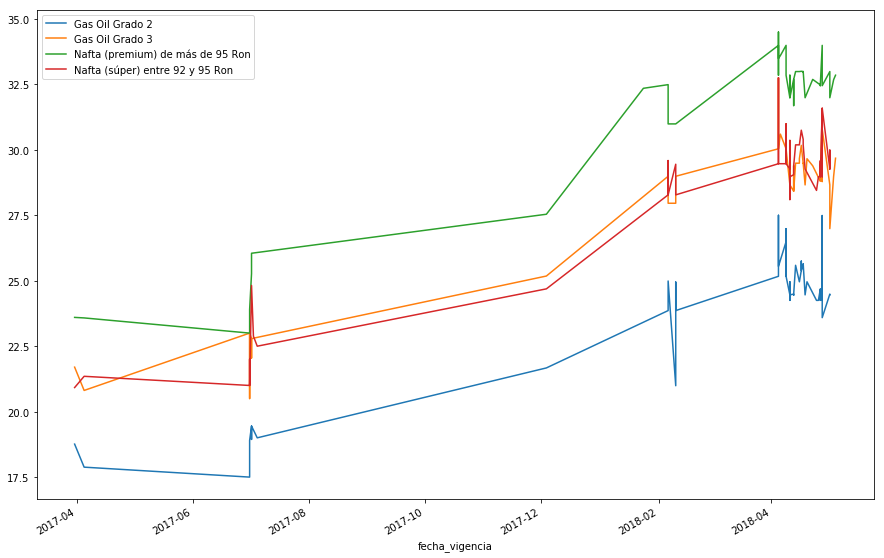

In [18]:
figure = plt.axes()
figure.figure.set_size_inches(15, 10)

for combustible in combustibles:
    combustible_corrientes = precios[
        (precios['producto'] == combustible) 
        & (precios['provincia'] == 'CORRIENTES')
    ]

    if not combustible_corrientes.empty:
        combustible_corrientes = combustible_corrientes[['fecha_vigencia', 'empresabandera', 'producto', 'precio']]
        combustible_corrientes.set_index(['fecha_vigencia'], inplace=True)
        combustible_corrientes.rename(columns={'precio': combustible}, inplace=True)

        combustible_corrientes.plot(ax=figure)
    
plt.show()

### ¿Cómo ha variado cada empresa los precios de la Nafta Super en Buenos Aires?

In [25]:
empresas = [
    'AXION', 
    'YPF', 
    'ESSO PETROLERA ARGENTINA S.R.L', 
    'PETROBRAS', 
    'SHELL C.A.P.S.A.', 
    'OIL COMBUSTIBLES S.A.'
]

precios_baires = precios[
    (precios['empresabandera'].isin(empresas))
    & (precios['provincia'] == 'BUENOS AIRES')
    & (precios['producto'] == 'Nafta (súper) entre 92 y 95 Ron')
]

precios_baires = precios_baires[['empresabandera', 'fecha_vigencia', 'precio']]
precio_minimos_empresa_idx = precios_baires.groupby(by='empresabandera')['fecha_vigencia'].idxmin()
precio_maximos_empresa_idx = precios_baires.groupby(by='empresabandera')['fecha_vigencia'].idxmax()

In [26]:
precio_minimos_empresa = precios_baires.loc[precio_minimos_empresa_idx].set_index('empresabandera')
precio_minimos_empresa

,fecha_vigencia,precio
empresabandera,,
AXION,2018-01-19,24.37
ESSO PETROLERA ARGENTINA S.R.L,2017-03-07,17.50
OIL COMBUSTIBLES S.A.,2017-02-10,19.49
PETROBRAS,2017-03-31,20.98
SHELL C.A.P.S.A.,2017-01-17,21.19
YPF,2017-02-10,20.99


In [27]:
precio_maximos_empresa = precios_baires.loc[precio_maximos_empresa_idx].set_index('empresabandera')
precio_maximos_empresa

,fecha_vigencia,precio
empresabandera,,
AXION,2018-05-14,26.98
ESSO PETROLERA ARGENTINA S.R.L,2018-05-14,27.98
OIL COMBUSTIBLES S.A.,2018-05-12,25.98
PETROBRAS,2018-05-15,26.59
SHELL C.A.P.S.A.,2018-05-16,26.78
YPF,2018-05-10,26.59


`.join()` une dos o más DataFrame através de su índice. El parámetro `lsuffix` es una string que se agregará al final del nombre de cada columna del dataframe que se encuentra a la izquierda (En nuestro caso, precio_maximos_empresa) y `rsuffix` es lo mismo pero para el dataframe que se encuentra a la derecha (precio_minimos_empresa).

In [28]:
precios_min_max = precio_maximos_empresa.join(precio_minimos_empresa, lsuffix='_max', rsuffix='_min')
precios_min_max

,fecha_vigencia_max,precio_max,fecha_vigencia_min,precio_min
empresabandera,,,,
AXION,2018-05-14,26.98,2018-01-19,24.37
ESSO PETROLERA ARGENTINA S.R.L,2018-05-14,27.98,2017-03-07,17.50
OIL COMBUSTIBLES S.A.,2018-05-12,25.98,2017-02-10,19.49
PETROBRAS,2018-05-15,26.59,2017-03-31,20.98
SHELL C.A.P.S.A.,2018-05-16,26.78,2017-01-17,21.19
YPF,2018-05-10,26.59,2017-02-10,20.99


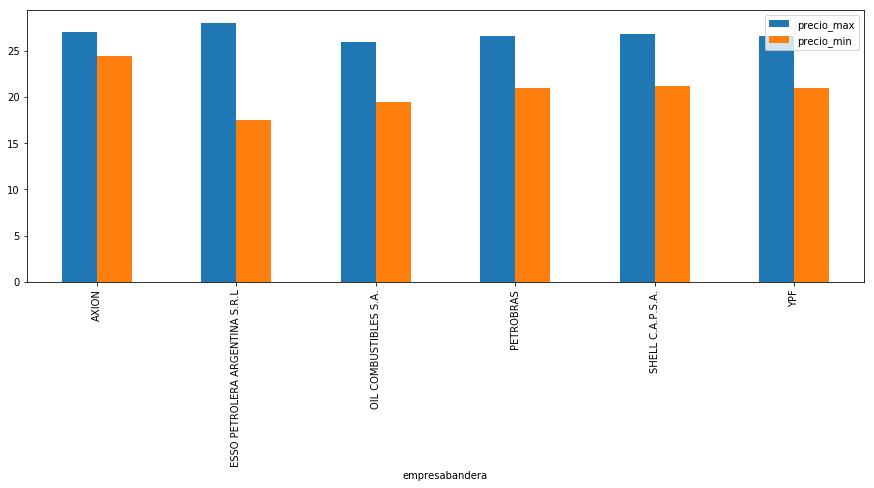

In [29]:
precios_min_max[['precio_max', 'precio_min']].plot(kind='bar', figsize=(15, 5))

# Conclusión
El análisis de datos consiste en conocer qué datos tenemos, cuales son sus características, explorar esos datos, comprender como se comportan las variables, pero lo más importante es **Hacerse preguntas y tratar de responderlas através de los datos.**
- Fuente de datos: http://datos.gob.ar/dataset/precios-surtidor---resolucion-3142016

### Algunos tips
* Soporta a múltiples formatos para leer y escribir:
    - CSV
    - HTML
    - JSON
    - Excel
    - SQL pd.read_sql(<span style="color:#C30019"> 'SELECT * FROM some_table'</span>, connection) /  pd.to_sql(<span style="color:#C30019">'some_table'</span>, connection)
    - [Y muchos más](https://pandas.pydata.org/pandas-docs/stable/io.html)
* El límite de un `DataFrame` es el límite de la memoria RAM.
* Me gustó! ¿Por donde empiezo?
    - [Cookbook](https://pandas.pydata.org/pandas-docs/stable/10min.html)
    - [10 Minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html)

# Muchas gracias!
https://medium.com/@cristhianboujon

https://www.linkedin.com/in/cristhian-boujon/